# MS Fidelity Estimations for QSCOUT

In [1]:
import scipy.constants
from scipy.constants import physical_constants
import qutip as qtp
import numpy as np
from numpy import exp, sqrt, sin
from math import factorial
import itertools
from operator import mul, add
import matplotlib.pyplot as plt
import seaborn as sb
import ast

ModuleNotFoundError: No module named 'seaborn'

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('../tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

In [3]:
π = np.pi

## QSCOUT parameters

In [4]:
# Ytterbium171
M=171*physical_constants['atomic mass constant'][0]

# Laser wavelength
# carrier_wavelen = # 355*1e-9 # 355nm, from "frequency robust ..." paper
# carrier_wavenum = 2*π/carrier_wavelen # Laser wavenumber (k)
# carrier_freq = scipy.constants.c*carrier_wavenum
qbit_splitting = 2*π*12.643*1e6 # qubit splitting, from "Engineering The ..." paper
raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c*np.sqrt(2)

# Rabi rate
Ωpeak = 2*π*190*1e3 # 190MHz, quoted in "Frequency-robust MS ..." paper

In [5]:
# Trap specifications
# Axial COM of 0.52MHz and highest radial mode of 2.296MHz are quoted in 
# "Frequency-robust Mølmer-Sørensen gates via balanced contributions of multiple motional modes"
νz = 2*π*0.52*1e6 # 0.52MHz
νr = 2*π*2.296*1e6 # 2.296MHz

In [6]:
# Optical Crosstalk, from "ENGINEERING THE QUANTUM SCIENTIFIC COMPUTING OPEN USER TESTBED"
# These values are scaled such that Ω=1 for the target ion
neighΩ = 0.0236 # Rabi frequency on neighbor of target ion
nneighΩ = 0.006 # Rabi frequency on next neighbor of target ion

In [7]:
# Blue and Red beam phases
# Below should implement X gate
ϕB = π/2
ϕR = π/2

In [8]:
N = 5
modetype="radial"
K = 1
τ = 200e-6 # 200μs

## Fidelity Calculations

In [9]:
N = 5
modetype="radial"
K = 1
τ = 200e-6 # 200μs

trapspec = TrapSpec(νz, νr)
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)

### Plot Generation Functions

In [10]:
def plotBestModes(N, fidarr, title=None):
    fig, axes = plt.subplots(2,3, figsize=(18,11), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.93, .3, .02, 0.5])
    cmap = sb.color_palette("rocket", as_cmap=True)
    for m in range(N):
        ax = axes.flat[m]
        annot = [[f"{m if m!=N-1 else 'COM'}" if (i==N//2 and j==N//2) else "" for i in range(N)] for j in range(N)]
        sb.heatmap(fidarr[:,:,m], ax=ax, vmin=0.94, vmax=1.0, cbar=(m==0),cbar_ax=None if m==1 else cbar_ax,
                   annot=annot, annot_kws={'c':'w', 'size':20}, fmt="", cmap=cmap,
                  xticklabels=[f"{i}" for i in range(N)])
        ax.set_yticklabels(ax.get_yticks(), size = 20)
        ax.set_xticklabels(ax.get_xticks(), size = 20)
    annot = [["" for i in range(N)] for j in range(N)]
    annot[N//2][N//2] = "Best"
    bestmodes = np.argmax(fidarr,2)
    bestfids = np.max(fidarr,2)
    for i in range(N):
        for j in range(i+1, N):
            annot[i][j] = f"{bestmodes[i,j]}"
            annot[j][i] = annot[i][j]
    ax_best = axes.flat[-1]
    sb.heatmap(bestfids, ax=ax_best, vmin=0.95, vmax=1.0, cbar=False,cbar_ax=cbar_ax,
              annot=annot, annot_kws={'c':'k', 'size':20}, fmt="", cmap=cmap)
    ax_best.set_xticklabels([f"{i}" for i in range(N)], size = 20)
    cbar_ax.figure.axes[-1].tick_params(labelsize=20)
    
    # bbox = ax_best.get_window_extent()
    # fig.patches.extend([plt.Rectangle((bbox.xmin, bbox.ymin),
    #                                   bbox.xmax-bbox.xmin, bbox.ymax-bbox.ymin,
    #                                   fill=True, color='g', alpha=0.7, zorder=-1, figure=fig)])
    
    fig.patches.extend([plt.Rectangle((985, 45),
                                      500, 460,
                                      fill=True, color='g', alpha=0.7, zorder=-1,
                                      transform=None, figure=fig)])
    
    ax_best.text(2.1, 2.6, "Best", c="w", size='20')
    if title!=None: fig.suptitle(title, size='25')

### Optical and Mode Crosstalk

In [11]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=list(range(N)),modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        illuminated = [i for i in range(N) if Ωvals[i]!=0]
        traceindices = [illuminated.index(i) for i in fidions]
        ρred = ρf.ptrace(traceindices)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

AttributeError: 'numpy.ndarray' object has no attribute 'norm'

TypeError: color_palette() got an unexpected keyword argument 'as_cmap'

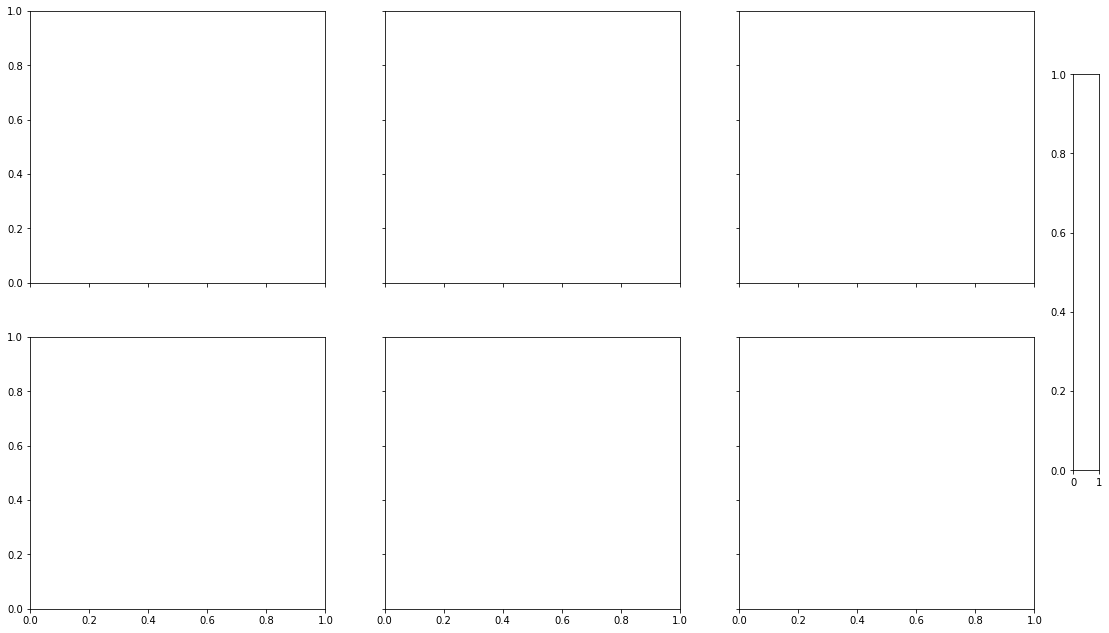

In [12]:
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Optical and Mode Xtalk")

### Optical Crosstalk, No Mode Crosstalk

In [13]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=[m],modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        ρred = ρf.ptrace(fidions)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withoutmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

AttributeError: 'numpy.ndarray' object has no attribute 'norm'

In [ ]:
file = open('calculated_results/qscout_5ion_fidelities_withopticalxtalk_withoutmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Optical Xtalk, No Mode Xtalk")

### Mode Crosstalk, No Optical Crosstalk

In [ ]:
fids = []
for targets, m in itertools.product(itertools.combinations(range(N),2), range(N)):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0, 0)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=list(range(N)),modetype=modetype, modetrunc=2)
    for fidions in itertools.combinations(range(N),2):
        ρred = ρf.ptrace(fidions)
        parity_curve_amplitude = 2*abs(ρred[3,0])
        pop00 = abs(ρred[0,0])
        pop11 = abs(ρred[3,3])
        measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
        fidcalc = MSFidCalculation(opspec=msopspec, method='MS_Analytical_zeroinitalstate_tracemodes', fid=measured_fid, fidions=fidions)
        fids.append(fidcalc)
file = open('calculated_results/qscout_5ion_fidelities_withoutopticalxtalk_withmodextalk', "w")
file.writelines([str(fidcalc)+'\n' for fidcalc in fids])

In [ ]:
file = open('calculated_results/qscout_5ion_fidelities_withoutopticalxtalk_withmodextalk', "r")
fids = [MSFidCalculation.fromDict(ast.literal_eval(line)) for line in file.readlines()]
fidarr = np.zeros((N,N,N))
for fidcalc in fids:
    if fidcalc.fidions == fidcalc.opspec.targets:
        targets = fidcalc.opspec.targets
        m = fidcalc.opspec.m
        fidarr[targets[0],targets[1],m] = fidcalc.fid
plotBestModes(N, fidarr, title="QSCOUT Estimates, 5 Ions, Mode Xtalk, No Optical Xtalk")

## Side Test: Consider spectator contributions in laser rabi freq calculation

In [ ]:
# def calc_necessary_sideband_detuning_and_rabi_freq_allmodecontrib(devicespec, targets, m, modetype, τ, K=1):
#     δ = 2*π*K/τ # Detuning is restricted by requirement to close phase-space loop
#     νm = devicespec.modes(modetype)[m].freq
#     ηki = lambda k, i : devicespec.LDparam(k, modetype, i)
#     pairηeff = 0
#     for k in range(N):
#         pairηeff += ηki(k,targets[0])*ηki(k,targets[1])/(δ+νm-devicespec.modes(modetype)[k].freq)
#     Ω = np.sqrt(δ/abs(4*K*pairηeff)) # Single rabi freq, meant for both target ions
#     return νm+δ, Ω

## Simulated Parity Curves

### Example

In [ ]:
targets = (1,3)
for m in range(N):
    ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
    Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, neighΩ, nneighΩ)
    mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
    msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=m, modetype=modetype, K=K)
    ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=[0,1,2,3,4],modetype=modetype, modetrunc=2)
    neighbors = [i for i in range(N) if i in [targets[0]-1,targets[0]+1,targets[1]-1,targets[1]+1] and i not in targets]
    plt.figure()
    ρred = ρf.ptrace(targets)
    paritycurve = parityCurve(ρred)
    amplitude = abs(np.max(paritycurve.T[1])-np.min(paritycurve.T[1]))
    plt.plot(*paritycurve.T, label=f"->{targets}:{amplitude}")
    for t in targets:
        for n in neighbors:
            ρred = ρf.ptrace((t,n))
            paritycurve = parityCurve(ρred)
            amplitude = abs(np.max(paritycurve.T[1])-np.min(paritycurve.T[1]))
            plt.plot(*paritycurve.T, label=f"{(t,n)}:{amplitude:.4f}")
    plt.legend()
    plt.title(f"Mode {m}")

## Non-Square Pulses

### Functions 

In [ ]:
def MS_non_square_pulse(opspec, simmodes=None, modetype='radial', modetrunc=2):
    '''
    Calculate
    
    '''
    devspec = opspec.devicespec
    N = devspec.N
    τ = opspec.duration
    Ωvals = opspec.mslaserspec.Ωvals
    Ωvals_temp = opspec.mslaserspec.Ωvals
    ωd = opspec.mslaserspec.ωd
    if opspec.modetype!=None: modetype = opspec.modetype
    ϕB = opspec.mslaserspec.ϕB
    ϕR = opspec.mslaserspec.ϕR
    ϕs = (ϕB+ϕR)/2
    ϕm = (ϕB-ϕR)/2
    laserphase = exp(1j*ϕm)

    print(opspec)
    νk = devspec.modes(modetype)[0].freq
    print(ωd)
    print(νk)
    print('--->',sum([Ωvals_temp[0](t)*exp(-1j*(ωd-νk)*t) for t in np.linspace(0,τ,1001)[:-1]])*τ/1000)
    
    if simmodes == None:
        simmodes = list(range(N))
    
    ρqbit_mat = np.zeros((2**N,2**N), dtype=np.cdouble)
    
    naturalbasis = list(itertools.product(*[[-1,+1]]*N))
    innerprod = 0
    for λ1,λ2 in itertools.product(naturalbasis, naturalbasis):
        # λ is a N-element list, representing a qubit state in the X basis (-1=|0>, +1=|1>).
        # We assume all λ values have equal initial coefficients
        # which corresponds to all |0> initial state in Z basis.
        λ1λ2coeff = 0
        for γ in list(itertools.product(*[list(range(modetrunc))]*len(simmodes))):
            # γ is a list of N integers, representing a mode state in the number basis
            # Used because we're tracing over all mode states
            displacementproduct = 1/2**(N) # Since each λ has equal coefficient to start
            for k in simmodes:
                νk = devspec.modes(modetype)[k].freq
                αλ1k = αλ2k = 0
                for i in range(N):
                    time_dependence = sum([Ωvals_temp[i](t)*exp(-1j*(ωd-νk)*t) for t in np.linspace(0,τ,1001)[:-1]])*τ/1000
                    ηki = devspec.LDparam(k, modetype, i)
                    αλ1k += ηki*λ1[i]*time_dependence*laserphase/2
                    αλ2k += ηki*λ2[i]*time_dependence*laserphase/2
                    #print(abs(coherent_coeff(αλ1k,modetrunc+1)))
                # if abs(αλ1k)>1 : print('++αλ1k', αλ1k, 'λ1', λ1, 'γ', γ, 'k', k)
                # if abs(αλ1k)<1 : print('--αλ1k', αλ1k, 'λ1', λ1, 'γ', γ, 'k', k)
                displacementproduct *= coherent_coeff(αλ1k, γ[simmodes.index(k)])
                displacementproduct *= coherent_coeff(αλ2k, γ[simmodes.index(k)]).conjugate()
            λ1λ2coeff += displacementproduct
        if λ1 == λ2: print(λ1λ2coeff)
        phaseangles = [0,0] # [λ1, λ2]
        for k in simmodes:
            νk = devspec.modes(modetype)[k].freq
            for j1, j2 in itertools.product(range(N),range(N)):
                ηkj1 = devspec.LDparam(k, modetype, j1)
                ηkj2 = devspec.LDparam(k, modetype, j2)
                time_dependence = sum([Ωvals[j1](time1)*\
                                       sum([Ωvals[j2](time2)*sin((ωd-νk)*(time1-time2))
                                            for time2 in np.linspace(0,time1,501)[:-1]])*time1
                                       for time1 in np.linspace(0,τ,501)[:-1]]) * τ/250000
                for a, λ in enumerate((λ1, λ2)):
                    #print(time_dependence*ηkj1*ηkj2*λ[j1]*λ[j2], flush=True)
                    phaseangles[a] += time_dependence*ηkj1*ηkj2*λ[j1]*λ[j2]
        λ1λ2coeff *= exp(-1j/4*phaseangles[0])*exp(-1j/4*phaseangles[1]).conjugate() # Conjugate for λ2
        λ1_index = int("".join(['0' if λ1[i]==-1 else '1' for i in range(N)]),2)
        λ2_index = int("".join(['0' if λ2[i]==-1 else '1' for i in range(N)]),2)
        ρqbit_mat[λ1_index, λ2_index] = λ1λ2coeff
        
    ρqbit = qtp.Qobj(ρqbit_mat, dims=[[2]*N,[2]*N])
    print(ρqbit.tr(),flush=True)
    
    σeigstates = σ(π/2+ϕs).eigenstates()
    σbasis = qtp.Qobj(np.c_[σeigstates[1][0].data.A, σeigstates[1][1].data.A],dims=[[2],[2]])
    change_of_basis = qtp.tensor([σbasis]*N)
    ρqbit_zbasis = change_of_basis*ρqbit*change_of_basis.dag()
    
    return ρqbit_zbasis

### Running

In [ ]:
N = 2
modetype="radial"
K = 1
τ = 200e-6 # 200μs

trapspec = TrapSpec(νz, νr)
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)

m=0
targets=(0,1)

z=τ/10
G = lambda t : exp(-(t-τ/2)**2/(2*z**2))


δ = -30000*2*π
ωd = devicespec.modes(modetype)[m].freq+δ

td = sum([G(time1)*sum([G(time2)*sin((δ)*(time1-time2))
                                            for time2 in np.linspace(0,time1,501)[:-1]])*time1
                                       for time1 in np.linspace(0,τ,501)[:-1]]) * τ/250000

td2 = sum([G(time1)*sum([G(time2)*sin((ωd-devicespec.modes(modetype)[1].freq)*(time1-time2))
                                            for time2 in np.linspace(0,time1,501)[:-1]])*time1
                                       for time1 in np.linspace(0,τ,501)[:-1]]) * τ/250000
print('td2 frac', td2/td, (ωd-devicespec.modes(modetype)[1].freq))

#ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
Ω = sqrt(abs((π/2)/(td*devicespec.LDparam(0,'radial',0)*devicespec.LDparam(0,'radial',1))))

Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0, 0)

Ωvals_timedep = [lambda t : Ωval*G(t) for Ωval in Ωvals]
#Ωvals_timedep = [lambda t : Ωval for Ωval in Ωvals]

mslaserspec = MSLaserSpec(ωd, Ωvals_timedep, ϕB, ϕR)
msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=0, modetype=modetype, K=K)

ρf = MS_non_square_pulse(msopspec, simmodes=[],modetype=modetype, modetrunc=2)

fidions = targets
ρred = ρf.ptrace(fidions)
parity_curve_amplitude = 2*abs(ρred[3,0])
pop00 = abs(ρred[0,0])
pop11 = abs(ρred[3,3])
measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
print(measured_fid)

In [ ]:
(devicespec.modes('radial')[0].freq-devicespec.modes('radial')[1].freq)/(2*π)

In [ ]:
Ω

In [ ]:
ωd - devicespec.modes('radial')[0].freq

In [ ]:
ρred

In [ ]:
N = 2
modetype="radial"
K = 1
τ = 200e-6 # 200μs

trapspec = TrapSpec(νz, νr)
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, raman_freq, M)

m=0
targets=(0,1)

z=τ/10
G = lambda t : exp(-(t-τ/2)**2/(2*z**2))


δ = 40000*2*π
ωd = devicespec.modes(modetype)[m].freq+δ

td = sum([G(time1)*sum([G(time2)*sin((δ)*(time1-time2))
                                            for time2 in np.linspace(0,time1,501)[:-1]])*time1
                                       for time1 in np.linspace(0,τ,501)[:-1]]) * τ/250000

ωd, Ω = calc_necessary_sideband_detuning_and_rabi_freq(devicespec, targets, m, modetype, τ, K=K)
#Ω = sqrt(abs((π/2)/(td*devicespec.LDparam(0,'radial',0)*devicespec.LDparam(0,'radial',1))))

Ωvals = Ω*Ωvals_from_fixed_neighbor_xtalk(N, targets, 0, 0)

#Ωvals_timedep = [lambda t : Ωval*G(t) for Ωval in Ωvals]
Ωvals_timedep = [lambda t : Ωval for Ωval in Ωvals]

mslaserspec = MSLaserSpec(ωd, Ωvals, ϕB, ϕR)
msopspec = MSOpSpec(devicespec, mslaserspec, τ, targets=targets, m=0, modetype=modetype, K=K)

ρf = MS_Analytical_zeroinitalstate_tracemodes(msopspec, simmodes=[0,1],modetype=modetype, modetrunc=2)

fidions = targets
ρred = ρf.ptrace(fidions)
parity_curve_amplitude = 2*abs(ρred[3,0])
pop00 = abs(ρred[0,0])
pop11 = abs(ρred[3,3])
measured_fid = (pop00 + pop11 + parity_curve_amplitude)/2
print(measured_fid)

In [ ]:
z=τ/10
G = lambda t : exp(-(t-τ/2)**2/(2*z**2))
sum([G(time1)*sum([G(time2)*sin((1000*2*π)*(time1-time2))
                                            for time2 in np.linspace(0,time1,1001)[:-1]])*time1
                                       for time1 in np.linspace(0,τ,1001)[:-1]]) * τ/1000000

In [ ]:
νz/(2*π)

In [ ]:
νr/(2*π)

In [ ]:
devicespec5 = TIDeviceSpec(5, trapspec, qbit_splitting, raman_freq, M)

In [ ]:
(devicespec5.modes('radial')[4].freq-devicespec5.modes('radial')[3].freq)/(2*π)

In [ ]:
1/τ

In [ ]:
5/65

In [ ]:
for numions in range(5,25):
    modes = ict.calcRadialModes(numions, νratio=6)
    freqs = np.array([(m, mode[0]) for m, mode in enumerate(modes)])
    plt.scatter([numions]*len(freqs), freqs[:,1], label=numions)
plt.legend()

In [ ]:
freqs[0,:]

In [ ]:
N=5
numgatessum = 0
for m in range(N):
    for t1, t2 in itertools.combinations(range(N),2):
        if N%2==1 and m%2==1 and (t1==N//2 or t2==N//2): continue
        neighbors = [i for i in range(N) if i in (t1-1,t1+1,t2-1,t2+1) and i not in (t1,t2)]
        numgates = 1+len(neighbors)*2
        print(t1, t2, numgates)
        numgatessum+=numgates
numgatessum